In [1]:
import os 
import matplotlib.pyplot as plt

print("Current path:", os.getcwd())
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

Current path: /home/ubuntu/BrainDecoding/notebooks


In [8]:
import os
import re
import numpy as np
import torch
import mne
from sklearn.preprocessing import RobustScaler
from functools import partial
from termcolor import cprint

def scale_clamp(X: np.ndarray, clamp_lim: float = 5.0, clamp: bool = True) -> np.ndarray:
  X = X.reshape(X.shape[0], -1)
  X = RobustScaler().fit_transform(X)
  if clamp:
      X = X.clip(min=-clamp_lim, max=clamp_lim)
  return X.squeeze()


class meg_dataset(torch.utils.data.Dataset):
  def __init__(self, config, s: int, train: bool):
    self.root = config['root_dir']
    nights = ['Night1', 'Night2', 'Night3', 'Night4']
    if s == 4 or s == 5:
      nights = ['Night1', 'Night3', 'Night4', 'Night5']
    np.random.seed(s)
    np.random.shuffle(nights)
    if train: 
      nights = nights[:3]
    else:
      nights = nights[3:]
    self.s = s
    s = f"S{int(s):02d}"
    mne.set_config('MNE_USE_CUDA', 'true')
    self.all_meg_data = []
    self.all_epochs = []
    cprint("Analysing Subject: " + s + ", nights: " + str(nights), 'blue', attrs=['bold'])
    for night in nights:
      print(f"Loading {s} {night}")
      data_path_folder = os.path.join(self.root, s, night)
      files = [f for f in os.listdir(data_path_folder)]
      files.sort()
      wm = files[-1]
      self.data_path = os.path.join(self.root, s, night, wm)

      raw = mne.io.read_raw_ctf(self.data_path, preload=True, verbose=False)
      raw.pick_types(meg=True, stim=True, eeg=False, ref_meg=False, verbose=False)
      if "MRP54-4016" in raw.ch_names:
        raw.drop_channels(["MRP54-4016"])
      if config["filter"]:
        raw.filter(config["filter_low"], config["filter_high"], picks='mag', n_jobs='cuda', h_trans_bandwidth=config["filter_high"]/10, l_trans_bandwidth=config["filter_low"]/10, verbose=False)
      events = mne.find_events(raw, stim_channel='UDIO001', initial_event=True, verbose=False)
      event_ids = {"maint_FACE": 43, "maint_HOUSE": 53}

      events[:,2] = events[:,2] - 255
      sel = np.where(events[:, 2] <= 255)[0]
      events = events[sel, :]
      picks = mne.pick_types(raw.info, meg='mag', eeg=False, stim=False, ref_meg=False)
      self.epochs = mne.Epochs(raw, events, event_ids,  picks=picks, tmin=0, tmax=4,\
                          baseline=None, preload=True, verbose=False)
      self.epochs.resample(120, verbose=False)
      self.epochs.apply_function(partial(scale_clamp, clamp_lim=config["clamp"]), verbose=False)
      self.meg_data = torch.from_numpy(self.epochs.get_data(picks='meg')).to(torch.float32)
      self.all_meg_data.append(self.meg_data)
      self.all_epochs.append(self.epochs)

    self.all_meg_data = torch.cat(self.all_meg_data, dim=0)
    for ep in self.all_epochs:
      ep.info['dev_head_t'] = self.all_epochs[0].info['dev_head_t']
    self.all_epochs = mne.concatenate_epochs(self.all_epochs, verbose=False)

    #np.random.shuffle(self.all_epochs.events[:, 2])
    
  def __len__(self):
    return len(self.all_meg_data)
  
  def __getitem__(self, idx):
    return self.all_meg_data[idx, :, :], self.all_epochs.events[idx, 2], self.s

In [ ]:
config = {
    "root_dir": "/vol/megdata/raw/",
    "clamp": 5.0,
    "filter": False,
    "filter_low": 0.3,
    "filter_high": 4,
}
subjects = 10
dataset = meg_dataset(
  config=config, s = subjects, train = False
)


Analysing Subject: S10, nights: ['Night2']
Loading S10 Night2


In [ ]:
meg, _, _ = dataset

In [ ]:
print("number of unique meg trials: ", len(np.unique(meg.numpy(), axis=0)))

In [ ]:
print(len(dataset))

400


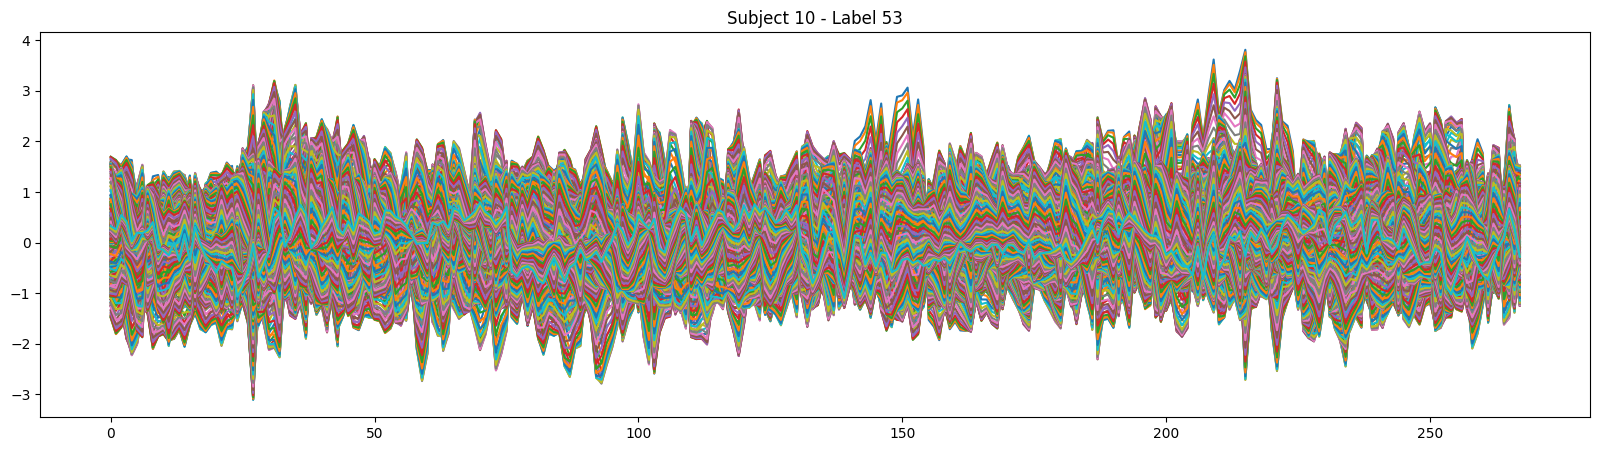

In [4]:
meg, label, subject = dataset[0]
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(meg)
ax.set_title(f"Subject {subject} - Label {label}")
plt.show()